# Uczenie Głębokie - Praca Domowa 1
## Autorzy
Jakub Kuniszewski 180125 <br>
Michał Kokoszkiewicz 197116

## Specjalizacja
Uczenie Maszynowe

## Komórki odpowiadające za pobranie i wstępne przygotowanie danych

Poniższa komórka pobiera zbiór danych z adresu URL pod którym dokładnie on się znajduje tak aby nie trzeba było tego robić manualnie. Następnie pobrany ZIP zostaje rozpakowany

In [1]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -n -q kagglecatsanddogs_5340.zip

--2023-12-25 18:01:26--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.65.244, 2600:1406:5e00:1a6::317f, 2600:1406:5e00:199::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.60.65.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   105MB/s    in 7.7s    

2023-12-25 18:01:34 (103 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



Zdefiniowana funkcja pozwoli przeczytać wszystkie zdjęcia psów i przekształcić je do wspólnej rozdzielczości 64x64 która jest maksymalną akceptowalną rozdzielczością według treści zadania. Konwersja przekształca zdjęcia również do skali szarości tak jak jest to wymagane.

In [2]:
import os
import cv2
import numpy as np
from tensorflow import keras

def load_and_preprocess_images(folder_path, target_size=(64, 64)):
    image_tensors = []

    # Assuming subfolders in the dataset folder are the class labels
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        # Load image
        if image_path.endswith('.jpg'):
          try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR, convert to RGB

            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = np.expand_dims(img, axis=-1)  # Add a singleton dimension for the channel

            # Resize image
            img = cv2.resize(img, target_size)

            # Normalize pixel values to be between 0 and 1
            img = img / 255.0

            image_tensors.append(img)
          except:
            print("Error with image: " + image_path)

    return np.array(image_tensors)

Wskazujemy ścieżkę do zbioru i wywołujemy funkcję. Jak widać z niektórymi zdjęciami są problemy, ale problem dotyczy tak niewielkiej porcji zdjęć że ignorujemy ten fakt.

In [3]:
dataset_path = "PetImages/Dog"
images = load_and_preprocess_images(dataset_path)

Error with image: PetImages/Dog/9188.jpg
Error with image: PetImages/Dog/6718.jpg
Error with image: PetImages/Dog/10401.jpg
Error with image: PetImages/Dog/2688.jpg
Error with image: PetImages/Dog/1866.jpg
Error with image: PetImages/Dog/11675.jpg
Error with image: PetImages/Dog/4367.jpg
Error with image: PetImages/Dog/1308.jpg
Error with image: PetImages/Dog/3136.jpg
Error with image: PetImages/Dog/11853.jpg
Error with image: PetImages/Dog/11410.jpg
Error with image: PetImages/Dog/6238.jpg
Error with image: PetImages/Dog/7133.jpg
Error with image: PetImages/Dog/3588.jpg
Error with image: PetImages/Dog/10747.jpg
Error with image: PetImages/Dog/7459.jpg
Error with image: PetImages/Dog/8730.jpg
Error with image: PetImages/Dog/11849.jpg
Error with image: PetImages/Dog/7969.jpg
Error with image: PetImages/Dog/3288.jpg
Error with image: PetImages/Dog/11702.jpg
Error with image: PetImages/Dog/7112.jpg
Error with image: PetImages/Dog/7369.jpg
Error with image: PetImages/Dog/5736.jpg
Error wit

Wypisujemy kształt tensora ze zdjęciami, 12470 zdjęć w rozdzielczości 64x64, skala szarości.

In [4]:
print(images.shape)
images = images[..., np.newaxis]
print(images.shape)

(12470, 64, 64)
(12470, 64, 64, 1)


Wyświetlamy pierwsze z brzegu zdjęcie aby upewnić się, że wszystko jest w porządku.

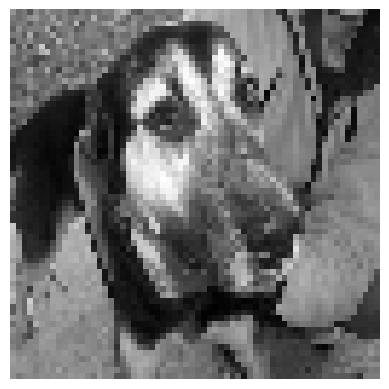

In [5]:
import matplotlib.pyplot as plt

plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()

Następnie dokonujemy podziału zbioru na treningowy i walidacyjny

In [6]:
print(images.shape)

(12470, 64, 64, 1)


## Komórki odpowiadające za definicję i trening modelu

In [7]:
import tensorflow as tf

np.random.seed(33)
tf.random.set_seed(33)
latent_dim = 1024
batch_size = 64
epochs = 100
hidden_units = 256

In [8]:
from keras.layers import Input, Dense, Lambda, Flatten, Conv2D, Activation, MaxPool2D, LayerNormalization, UpSampling2D, Reshape
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy

Poniżej definiujemy Callback który będzie spełniał wymaganie zadania domowego, do 10 epoki wartość beta pozostaje na poziomie 0.01, a później jest powoli zwiększana.

In [9]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
latent_dim = 1024

encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 16384)                0         ['conv2d_1[0][0]']            
                                                                                            

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 16384)             16793600  
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 1)         289 

In [13]:
from keras.callbacks import LambdaCallback
import keras.backend as K
initial_beta = 0.01  # Initial value of beta
beta = K.variable(initial_beta, name="beta")

class BetaAnnealingCallback(LambdaCallback):
    def __init__(self, schedule):
        super(BetaAnnealingCallback, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        new_beta = self.schedule(epoch)
        K.set_value(beta, new_beta)
        print(f'Current epoch: {epoch}, Beta: {new_beta}')

# Schedule for beta annealing (you can customize this)
def beta_schedule(epoch):
    if epoch < 10:
        return 0.01  # Start with a low value
    else:
        return min(1.0, epoch / 100.0)  # Gradually increase to 1.0

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.beta = 0.01
        self.initial_beta = 0.01
        self.epoch = 0
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) * beta
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": beta
        }

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(images, epochs=100, batch_size=128, callbacks=[BetaAnnealingCallback(beta_schedule)])

Current epoch: 0, Beta: 0.01
Epoch 1/30
98/98 [==============================] - 14s 48ms/step - loss: 2787.4279 - reconstruction_loss: 2733.6145 - kl_loss: 1.6325 - beta: 0.0100
Current epoch: 1, Beta: 0.01
Epoch 2/30
98/98 [==============================] - 4s 39ms/step - loss: 2623.8470 - reconstruction_loss: 2603.7454 - kl_loss: 3.8816 - beta: 0.0100
Current epoch: 2, Beta: 0.01
Epoch 3/30
98/98 [==============================] - 3s 36ms/step - loss: 2588.7987 - reconstruction_loss: 2582.4097 - kl_loss: 4.2610 - beta: 0.0100
Current epoch: 3, Beta: 0.01
Epoch 4/30
98/98 [==============================] - 3s 34ms/step - loss: 2585.5803 - reconstruction_loss: 2579.5020 - kl_loss: 3.9070 - beta: 0.0100
Current epoch: 4, Beta: 0.01
Epoch 5/30
98/98 [==============================] - 3s 34ms/step - loss: 2583.8985 - reconstruction_loss: 2577.5708 - kl_loss: 3.7753 - beta: 0.0100
Current epoch: 5, Beta: 0.01
Epoch 6/30
98/98 [==============================] - 3s 34ms/step - loss: 2581.16

## Generowanie nowych przykładów

Latent sample:  [[-0.31885351 -1.60298056 -1.53521787 ...  1.00772076 -1.44785781
   1.28122982]
 [ 2.13669714 -0.57866402  0.47697971 ...  0.65364894  0.19489186
  -0.49518888]
 [-0.68909225 -0.95719941  0.15876757 ...  1.26417765 -1.75380751
   2.18877771]
 ...
 [-0.34512403  1.92058198 -0.19442997 ...  0.73008862  1.5110005
   0.98753308]
 [ 1.43240665  0.82956302 -0.27507706 ...  0.09660891  0.37762946
   0.16158137]
 [-0.38295692  0.30985704 -0.44603811 ...  0.41826004  0.08660917
   0.24114557]]
1/1 [==============================] - 0s 332ms/step
Generated images: 


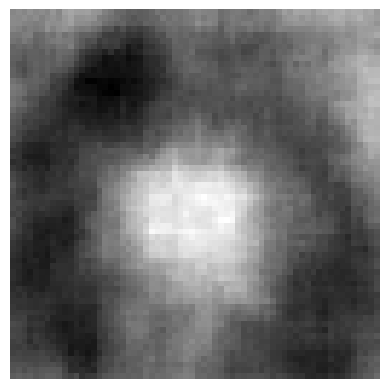

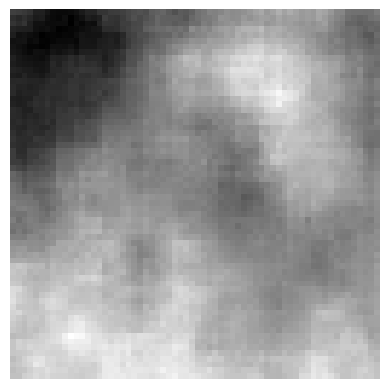

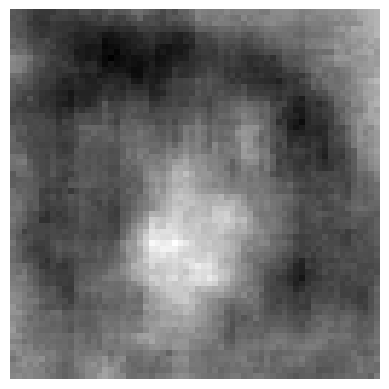

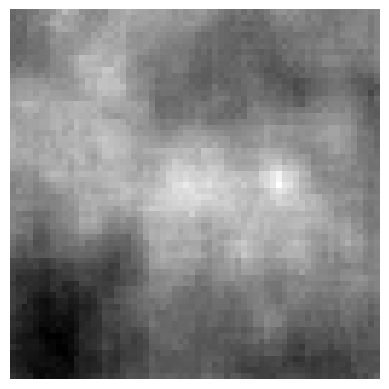

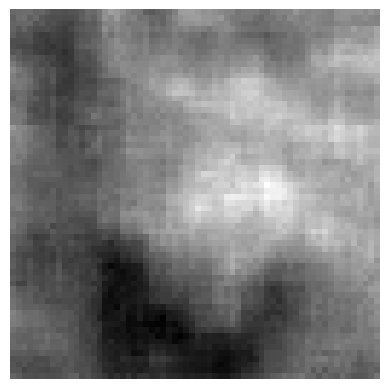

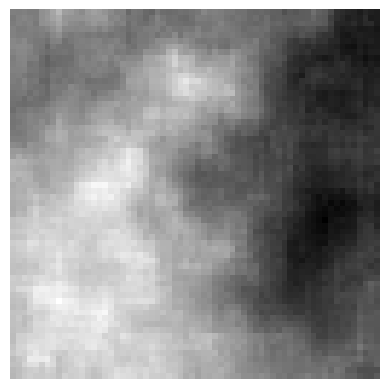

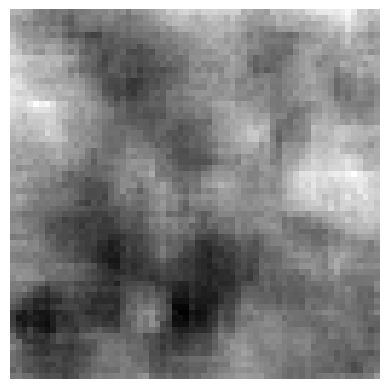

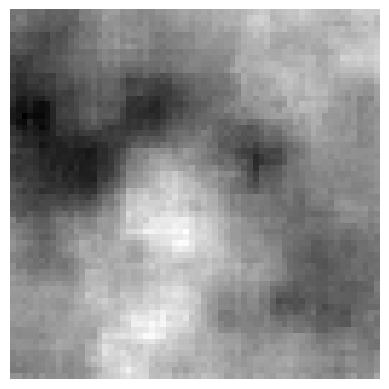

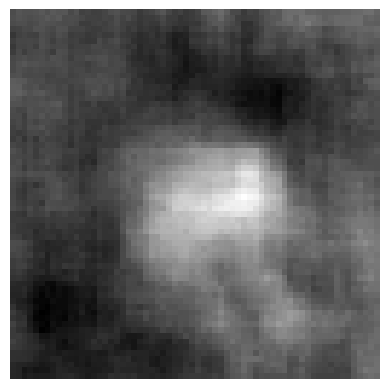

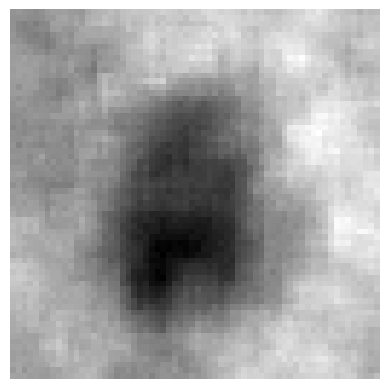

In [15]:
selected_gen = 10
latent_sample = np.random.normal(0,1,size=[selected_gen, latent_dim])

print("Latent sample: ", latent_sample)

input_decoded = decoder.predict(latent_sample)
dogs = input_decoded.reshape((selected_gen,64,64))

print("Generated images: ")
for i in range(selected_gen):
  plt.imshow(dogs[i, :, :], cmap='gray')
  plt.axis('off')
  plt.show()